In [1]:
import os
import tensorflow as tf
import cv2
import tensorflow.keras
from keras.layers import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras.models import Model

#Data set

In [2]:
(train_im,y_train),(test_im,y_test)=tensorflow.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
train_im.shape

(50000, 32, 32, 3)

In [4]:
y_train=y_train.reshape(-1,)

In [5]:
train_im=train_im/225

#activation function

In [15]:
def custom_activation(x):
  result = tf.where(x >= 0, x, 0)
  return result

In [16]:
def threshold(x):
  result = tf.where(x >= 0.10332, x, tf.where(x <= -0.10332, x, 0))
  return result

#model

In [17]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(custom_activation)(x)

  return x

In [18]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(custom_activation)(x)

  return x

In [19]:
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(10, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [20]:
model = resnet50()

In [21]:
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 16, 16, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_53 (BatchN  (None, 16, 16, 64)  256         ['conv2d_53[0][0]']       

In [22]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
history=model.fit(train_im,y_train,epochs=160)

Epoch 1/160
1563/1563 [==============================] - 100s 41ms/step - loss: 12.9810 - accuracy: 0.2971
Epoch 2/160
1563/1563 [==============================] - 62s 40ms/step - loss: 6.0102 - accuracy: 0.3501
Epoch 3/160
1563/1563 [==============================] - 61s 39ms/step - loss: 4.6922 - accuracy: 0.2968
Epoch 4/160
1563/1563 [==============================] - 61s 39ms/step - loss: 3.9142 - accuracy: 0.2949
Epoch 5/160
1563/1563 [==============================] - 61s 39ms/step - loss: 3.7138 - accuracy: 0.3175
Epoch 6/160
1563/1563 [==============================] - 63s 40ms/step - loss: 3.1687 - accuracy: 0.3382
Epoch 7/160
1563/1563 [==============================] - 60s 39ms/step - loss: 2.5772 - accuracy: 0.3798
Epoch 8/160
1563/1563 [==============================] - 60s 38ms/step - loss: 2.5953 - accuracy: 0.3996
Epoch 9/160
1563/1563 [==============================] - 60s 39ms/step - loss: 2.3298 - accuracy: 0.4305
Epoch 10/160
1563/1563 [=============================

In [24]:
y_prob=model.predict(test_im)
y_pred=y_prob.argmax(axis=1)

313/313 [==============================] - 4s 10ms/step


In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.1914

Text(0, 0.5, 'Loss')

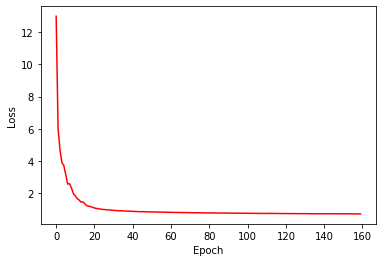

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.plot(history.history['loss'],'r')
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

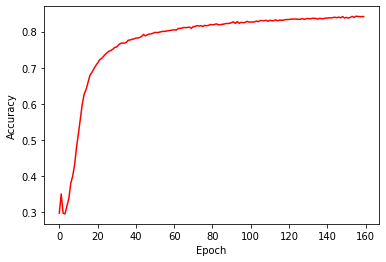

In [28]:
plt.plot(history.history['accuracy'],'r')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

[Text(0.5, 15.0, 'True values'), Text(33.0, 0.5, 'Predicted values')]

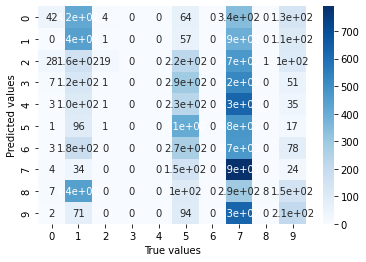

In [29]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
ax=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set(xlabel="True values", ylabel="Predicted values")